In [25]:
# cargamos librerías necesarias
import numpy  as np  
import pandas as pd
from time import time

import matplotlib.pyplot as plt # para dibujar
%matplotlib inline

# Problema de regresión (diamonds)

## 1. Cargar datos

In [2]:
diamonds_data = pd.read_csv("./diamonds.csv",sep=',',decimal='.') # cargamos fichero

print('Dimensiones: (%i,%i)' %diamonds_data.shape)
diamonds_data.head(5)   

Dimensiones: (53940,11)


,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
diamonds_data.dtypes

Unnamed: 0      int64
carat         float64
cut            object
color          object
clarity        object
depth         float64
table         float64
price           int64
x             float64
y             float64
z             float64
dtype: object

In [4]:
diamonds_data = diamonds_data.drop(['Unnamed: 0'],axis=1)

In [5]:
diamonds_data.head(5)   

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Tenemos 3 variables categóricas y 7 numéricas

In [6]:
diamonds_data.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


Todas las variables estan informadas en todas las 53940 muestras.

En el caso de las variables de tamaño **x,y,z** vemos que hay valores 0, cosa que no tiene sentido y posiblemente serán errores. Tanto en el caso de **X** como de **y** tenemos máximos muy alejados del percentil 75 lo que hace pensar en valores anómalos

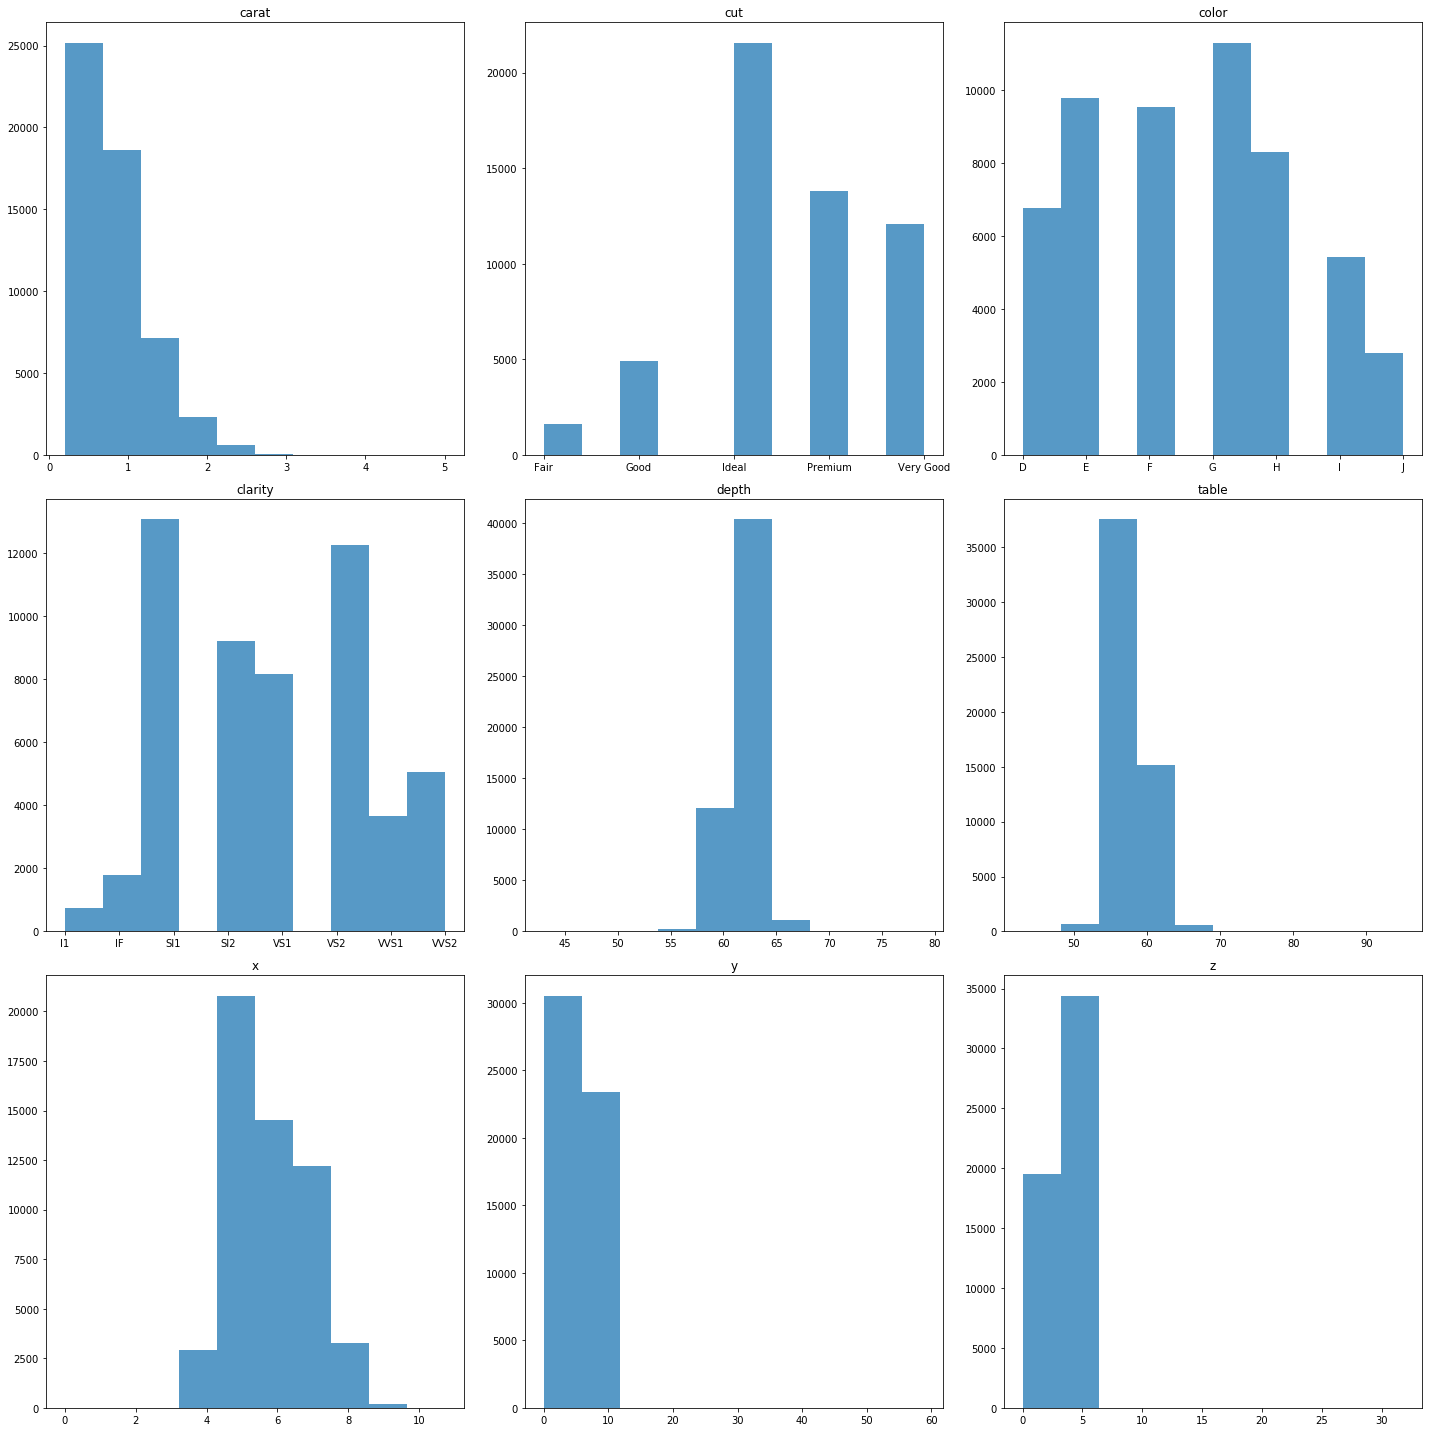

In [7]:

plt.figure(figsize=(20,20))

for i,feature in enumerate(diamonds_data.columns.drop(['price'])):
    plt.subplot(3,3,i+1)   
    plt.hist(diamonds_data.loc[:,feature],normed=0, alpha=0.75)
    plt.title(feature)

plt.tight_layout()

Veamos ahora la posible correlación entre las variables

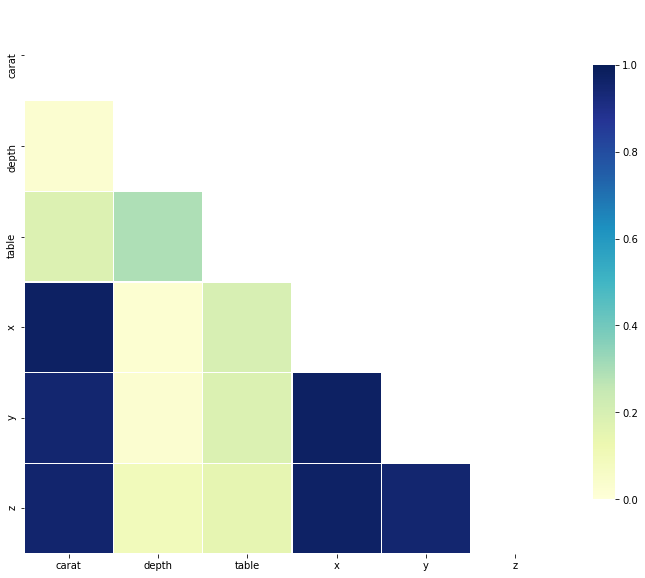

In [8]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(diamonds_data.drop(['price'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

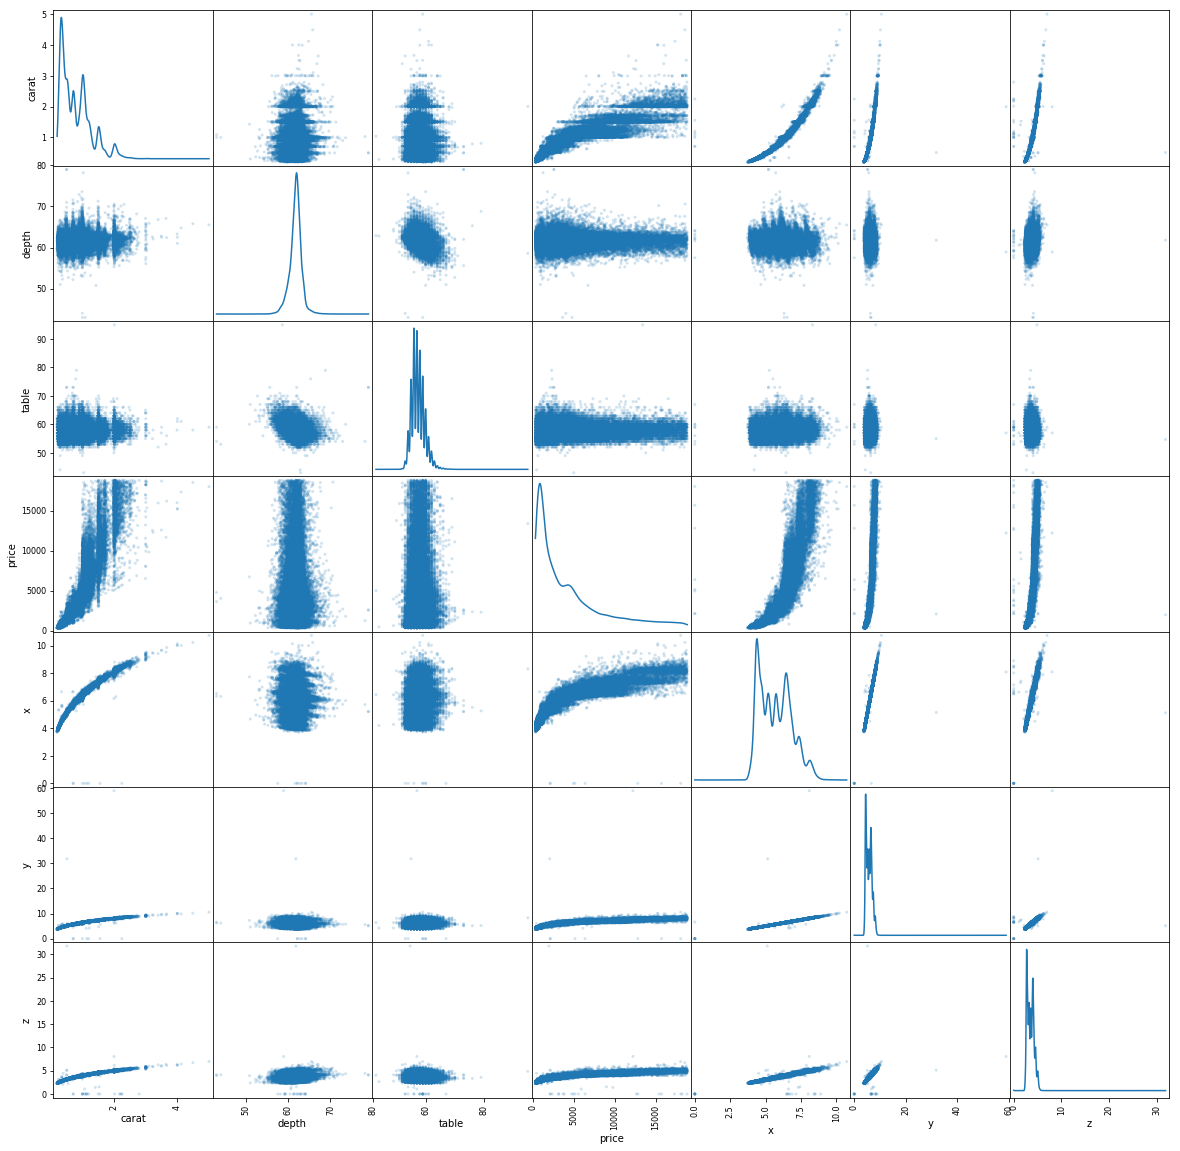

In [9]:
pd.plotting.scatter_matrix(diamonds_data, alpha=0.2, figsize=(20, 20), diagonal = 'kde')
plt.show()

Podemos ver que hay mucha correlación entre las variables **x,y,z ** y estas a su vez con el **precio**.

Transformaremos estas tres variables en una sola para reducir la dimensionalidad y por tanto la complejidad del modelo.

Multiplicando las tres variables obtenemos el volumen del diamante y podremos eliminarlas

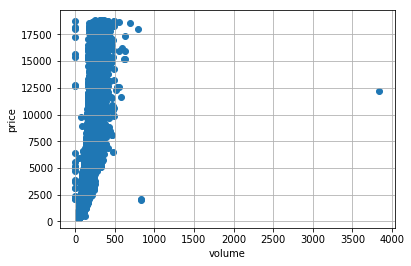

,volume,price
volume,1.000000,0.902385
price,0.902385,1.000000


In [10]:
# Creamos la nueva variable
diamonds_data['volume'] = diamonds_data['x'] * diamonds_data['y'] * diamonds_data['z']

# Eliminamos las 3 que hemos usado para crear la nueva
diamonds_data = diamonds_data.drop(['x','y','z'], axis=1)

# Veamos la correlación de la nueva variable con el precio
plt.scatter(diamonds_data['volume'],diamonds_data['price'])
plt.grid()
plt.xlabel('volume')
plt.ylabel('price')
plt.show()
diamonds_data.loc[:,['volume','price']].corr()


In [11]:
diamonds_data['volume'].describe()

count    53940.000000
mean       129.849403
std         78.245262
min          0.000000
25%         65.136830
50%        114.808572
75%        170.842451
max       3840.598060
Name: volume, dtype: float64

Hay una correlación elevada entre el **volumen** y el **precio**, pero vemos que hay algunos posibles outliers que vamos a elimanar

In [12]:
tmp = diamonds_data[(diamonds_data['volume'] > 0) & (diamonds_data['volume'] < 700)] 
eliminados = diamonds_data.shape[0] - tmp.shape[0]
porcentage_eliminados = eliminados * 100.0 / diamonds_data.shape[0]
print('Eliminaremos %i muestras que suponen un %0.3f por cien del total' %(eliminados,porcentage_eliminados))


Eliminaremos 24 muestras que suponen un 0.044 por cien del total


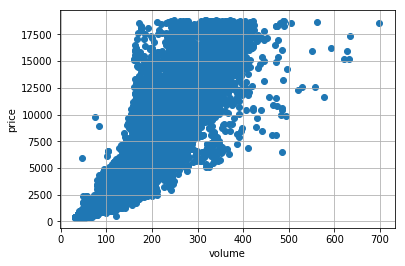

(53916, 8)


,volume,price
volume,1.000000,0.923726
price,0.923726,1.000000


In [13]:
diamonds_data = diamonds_data[(diamonds_data['volume'] > 0) & (diamonds_data['volume'] < 700)] 
plt.scatter(tmp['volume'],tmp['price'])
plt.grid()
plt.xlabel('volume')
plt.ylabel('price')
plt.show()
print(diamonds_data.shape)
tmp.loc[:,['volume','price']].corr()


La correlación es mayor, pero ya se ve que la relación no es lineal (aunque seguramente un simple polinomio de grado 2  nos daria una estimación aceptable)

### Veamos ahora las variables categóricas

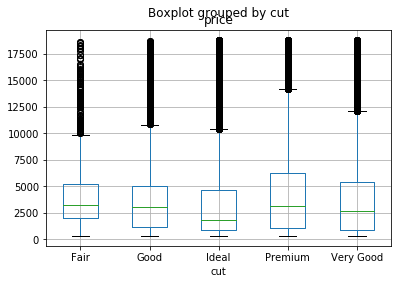

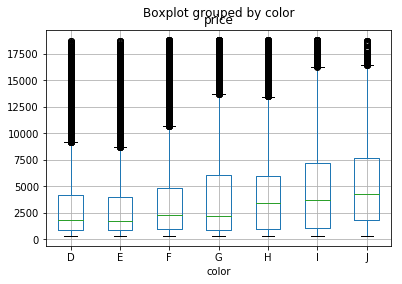

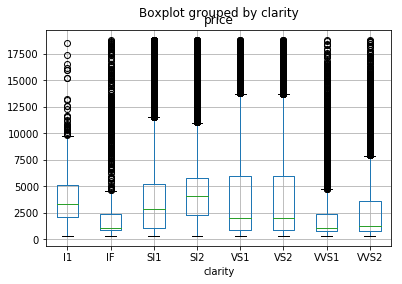

In [16]:
variables_categoricas = ['cut','color','clarity']
for v in variables_categoricas:
    diamonds_data.boxplot(by=v,column = 'price')    

Vemos que las tres variables categóricas se mueven en rangos muy iguales en cuanto al precio, al estar los rangos tan solapados no se puede distinguir ninguna clase como representativa de un precio

¿Como codificar estas variables categoricas?

Hay que notar que en cada una de estas tres variables el orden es importante, así tenemos (de menor a mayor valor):

   - **cut**: Fair, Good, Very Good, Ideal, Premium
   - **color**: J, I, H, G, F, E, D
   - **clarity**: I1, SI2, SI1, VS2, VS1, VVS2, VVS1, IF

In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

print("cut: ",list(le.fit(diamonds_data['cut']).classes_))
print("color: ",list(le.fit(diamonds_data['color']).classes_))
print("clarity: ",list(le.fit(diamonds_data['clarity']).classes_))

('cut: ', ['Fair', 'Good', 'Ideal', 'Premium', 'Very Good'])
('color: ', ['D', 'E', 'F', 'G', 'H', 'I', 'J'])
('clarity: ', ['I1', 'IF', 'SI1', 'SI2', 'VS1', 'VS2', 'VVS1', 'VVS2'])


Usando *LabelEndocer* solo conseguimos preservar la ordenación en el caso de **color** (aun que sea inverso).

Para las otras dos variables no nos sirve esta ordenación y la haremos de forma manual

In [18]:
data = diamonds_data.copy()

# codificamos el color con LabelEncoder
data['color'] = le.fit_transform(data['color'])

# Codificamos el corte de forma manual y cambiamos el tipo de dato
cut_order = ['Fair', 'Good', 'Very Good', 'Ideal', 'Premium']
for i,v in enumerate(cut_order):
    idx = data['cut'] == v
    data.loc[idx,'cut'] = i
data['cut'] = data['cut'].astype(int)

# Codificamos la claridad de forma manual y cambiamos el tipo de dato
clarity_order = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
for i,v in enumerate(clarity_order):
    idx = data['clarity'] == v
    data.loc[idx,'clarity'] = i
data['clarity'] = data['clarity'].astype(int)

data.head(10)

,carat,cut,color,clarity,depth,table,price,volume
0,0.23,3,1,1,61.5,55.0,326,38.202030
1,0.21,4,1,2,59.8,61.0,326,34.505856
2,0.23,1,1,4,56.9,65.0,327,38.076885
3,0.29,4,5,3,62.4,58.0,334,46.724580
4,0.31,1,6,1,63.3,58.0,335,51.917250
5,0.24,2,6,5,62.8,57.0,336,38.693952
6,0.24,2,5,6,62.3,57.0,336,38.830870
7,0.26,2,4,2,61.9,55.0,337,42.321081
8,0.22,0,1,3,65.1,61.0,337,36.425214
9,0.23,2,4,4,59.4,61.0,338,38.718000


In [19]:
diamonds_data.head(10)

,carat,cut,color,clarity,depth,table,price,volume
0,0.23,Ideal,E,SI2,61.5,55.0,326,38.202030
1,0.21,Premium,E,SI1,59.8,61.0,326,34.505856
2,0.23,Good,E,VS1,56.9,65.0,327,38.076885
3,0.29,Premium,I,VS2,62.4,58.0,334,46.724580
4,0.31,Good,J,SI2,63.3,58.0,335,51.917250
5,0.24,Very Good,J,VVS2,62.8,57.0,336,38.693952
6,0.24,Very Good,I,VVS1,62.3,57.0,336,38.830870
7,0.26,Very Good,H,SI1,61.9,55.0,337,42.321081
8,0.22,Fair,E,VS2,65.1,61.0,337,36.425214
9,0.23,Very Good,H,VS1,59.4,61.0,338,38.718000


Comparando con el original vemos que se ha hecho la transformación correctamente

Ahora que ya tenemos los datos como los queremos, procedemos a crear los conjuntos de entrenamiento y test para los modelos

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# preparamos los datos

features = data.columns.drop('price')

X = data[features].as_matrix()
y = data['price'].as_matrix()


# Dividimos las muestras en train (75%) y test (25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle=True, random_state=0)


# Realizamos un escalado para que todas las variables esten en un mismo rango
scaler = StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_test  = scaler.transform(X_test)

print('Datos train: ', Xs_train.shape)
print('Datos test:  ', Xs_test.shape)


('Datos train: ', (40437L, 7L))
('Datos test:  ', (13479L, 7L))


## Creación y evaluación de modelos
Ahora que ya tenemos los datos preparados pasamos a la creación y evaluación de modelos de predicción, empezando con los más sencillos.

Empezamos con una regresión polinómica probando diferentes grados y sin regularización 

In [21]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score
    
mse_train = []
mse_test = []
r2_train = []
r2_test = []

max_degree = 6

for degree in range(1,max_degree+1):   
    poly    = PolynomialFeatures(degree) 
    
    Xp_train = poly.fit_transform(Xs_train)
    Xp_test = poly.fit_transform(Xs_test)
  
    lr = LinearRegression().fit(Xp_train,y_train)
    
    # prediccion de train
    y_hat_train = lr.predict(Xp_train)
    
    mse = np.mean(np.power(y_train - y_hat_train,2))
    mse_train.append(mse)
    r2_train.append(r2_score(y_train, y_hat_train))
    
    # predicción de test
    y_hat_test = lr.predict(Xp_test)

    mse = np.mean(np.power(y_test - y_hat_test,2))
    mse_test.append(mse)
    r2_test.append(r2_score(y_test, y_hat_test))

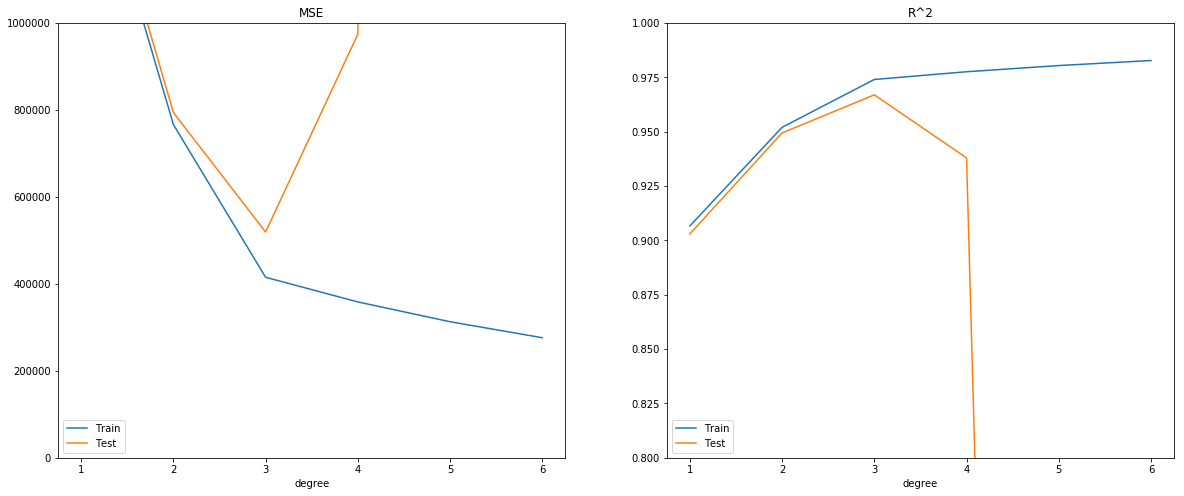

In [22]:

plt.figure(figsize=(20,8))

plt.subplot(1,2,1)   
plt.plot(range(1,max_degree+1), mse_train, label='Train')
plt.plot(range(1,max_degree+1), mse_test, label='Test')
plt.ylim([0, 1e6])
plt.legend(loc='lower left')
plt.xlabel('degree')
plt.title('MSE')

plt.subplot(1,2,2)   
plt.plot(range(1,max_degree+1), r2_train, label='Train')
plt.plot(range(1,max_degree+1), r2_test, label='Test')
plt.ylim([0.8,1])
plt.legend(loc='lower left')
plt.xlabel('degree')
plt.title('R^2')

plt.show()

Vemos que la mejor opción es el polinomio de grado 3, ya que a partir de aquí su comportamiento en test es muy malo

In [23]:
print('MSE train polinomio grado 3: %f' %mse_train[2])
print('MSE test  polinomio grado 3: %f' %mse_test[2])

print('R2 train polinomio grado 3: %f' %r2_train[2])
print('R2 test  polinomio grado 3: %f' %r2_test[2])

MSE train polinomio grado 3: 415087.581992
MSE test  polinomio grado 3: 519167.325365
R2 train polinomio grado 3: 0.973994
R2 test  polinomio grado 3: 0.966919


Conseguimos un R2 del 96% en test que además es muy parecido al de train 97% con lo que entiendo que no debería haber overfiting

Probemos si lo mejoramos utilizando regularización **Lasso** con el polinomio de grado 3

932.35800004
best mean cross-validation score: 0.972
best parameters: {'alpha': 3.2245905452963948}
test-set score: 0.97


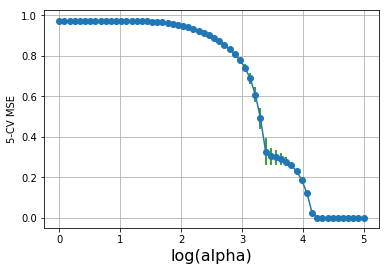

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

poly = PolynomialFeatures(3) 
    
# creamos todas las combinaciones de polinomios de grado 3 con las vairables escaladas    
Xp_train = poly.fit_transform(Xs_train)
Xp_test = poly.fit_transform(Xs_test)

    
alpha_vector = np.logspace(0,5 , 60)
param_grid = {'alpha': alpha_vector}


start = time()

grid = GridSearchCV(Lasso(), param_grid=param_grid,scoring= 'r2', cv = 5).fit(Xp_train, y_train)

end = time()
print(end - start)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.2f}".format(grid.score(Xp_test, y_test)))

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']
plt.errorbar(np.log10(alpha_vector),scores,yerr=std_scores, fmt='o-',ecolor='g')
plt.xlabel('log(alpha)',fontsize=16)
plt.ylabel('5-CV MSE')
plt.grid()
plt.show()

In [66]:
from sklearn.metrics import mean_squared_error,r2_score

alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(Xp_train,y_train)

ytrainLasso = lasso.predict(Xp_train)
ytestLasso  = lasso.predict(Xp_test)

mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

r2TrainModelLasso = r2_score(y_train,ytrainLasso)
r2TestModelLasso = r2_score(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

print('R2 Modelo Lasso (train): %0.3g' % r2TrainModelLasso)
print('R2 Modelo Lasso (test) : %0.3g' % r2TestModelLasso)

print('')
print('Tenemos %i coeficientes, pero hemos eliminado %i' %(lasso.coef_.size,sum(lasso.coef_ == 0)))


MSE Modelo Lasso (train): 4.27e+05
MSE Modelo Lasso (test) : 4.21e+05
R2 Modelo Lasso (train): 0.973
R2 Modelo Lasso (test) : 0.973

Tenemos 120 coeficientes, pero hemos eliminado 45


No ha habido mucha diferencia, pero hemos acortado mas la distancia entre los errores de train y test lo cual es positivo.

Además hemos eliminado 45 variables (haciendo 0 sus coeficientes) por lo que simplificamos el modelo.

**Probemos con GradientBoostingRegressor**

In [51]:
from sklearn.ensemble import GradientBoostingRegressor

Niterations = [500,1000,1500,2000, 2500]
learningRate = [0.1,0.05,0.01]
# mantenemos max_depth estático: max_depth=3

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid = GridSearchCV(GradientBoostingRegressor(random_state=0, max_depth=3), param_grid=param_grid, cv = 5)
grid.fit(Xs_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.981
best parameters: {'n_estimators': 2500, 'learning_rate': 0.05}


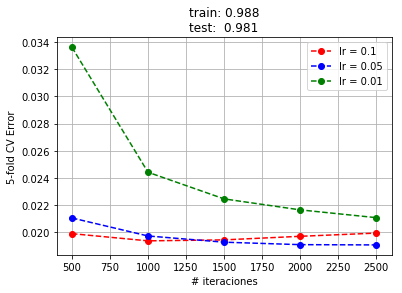

In [52]:
bt = GradientBoostingRegressor(random_state=0, max_depth=3,learning_rate= 0.05, n_estimators= 2500)
bt.fit(Xs_train,y_train)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(Xs_train,y_train),bt.score(Xs_test,y_test)))
plt.grid()
plt.show()

In [57]:
ytrainBt = bt.predict(Xs_train)
ytestBt  = bt.predict(Xs_test)

mseTrainModelBt = mean_squared_error(y_train,ytrainBt)
mseTestModelBt = mean_squared_error(y_test,ytestBt)

r2TrainModelBt = r2_score(y_train,ytrainBt)
r2TestModelBt = r2_score(y_test,ytestBt)

print('MSE Modelo GradientBoostingRegressor (train): %0.3g' % mseTrainModelBt)
print('MSE Modelo GradientBoostingRegressor (test) : %0.3g' % mseTestModelBt)

print('R2 Modelo GradientBoostingRegressor (train): %0.3g' % r2TrainModelBt)
print('R2 Modelo GradientBoostingRegressor (test) : %0.3g' % r2TestModelBt)


MSE Modelo GradientBoostingRegressor (train): 1.93e+05
MSE Modelo GradientBoostingRegressor (test) : 2.97e+05
R2 Modelo GradientBoostingRegressor (train): 0.988
R2 Modelo GradientBoostingRegressor (test) : 0.981


Hemos alcanzado un R2 del 98% tanto en train como en test y hemos reducido algo el MSE respecto al Lasso, por lo que daremos este resultado como definitivo.

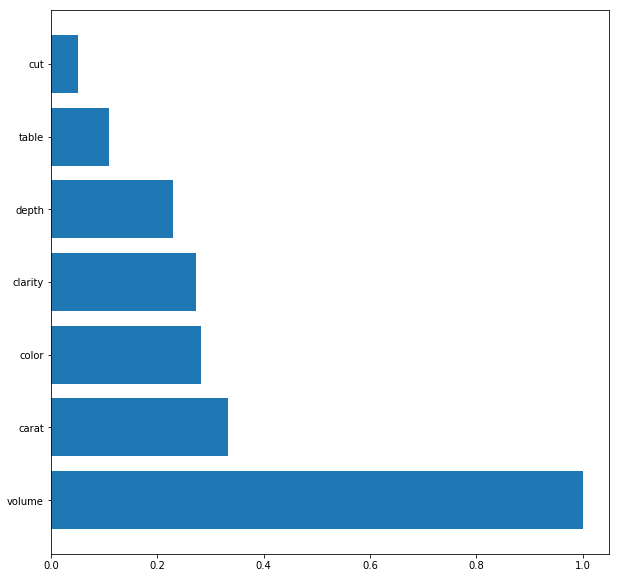

In [53]:
importances = bt.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]


plt.figure(figsize=(10,10))
plt.barh(range(Xs_train.shape[1]),importances[indices])
plt.yticks(range(Xs_train.shape[1]),features[indices])
plt.show()

Tal como esperábamos después del análisis exploratorio, la variable mas importante para este modelo es el **volumen** y con mucha menos relevancia los **quilates**

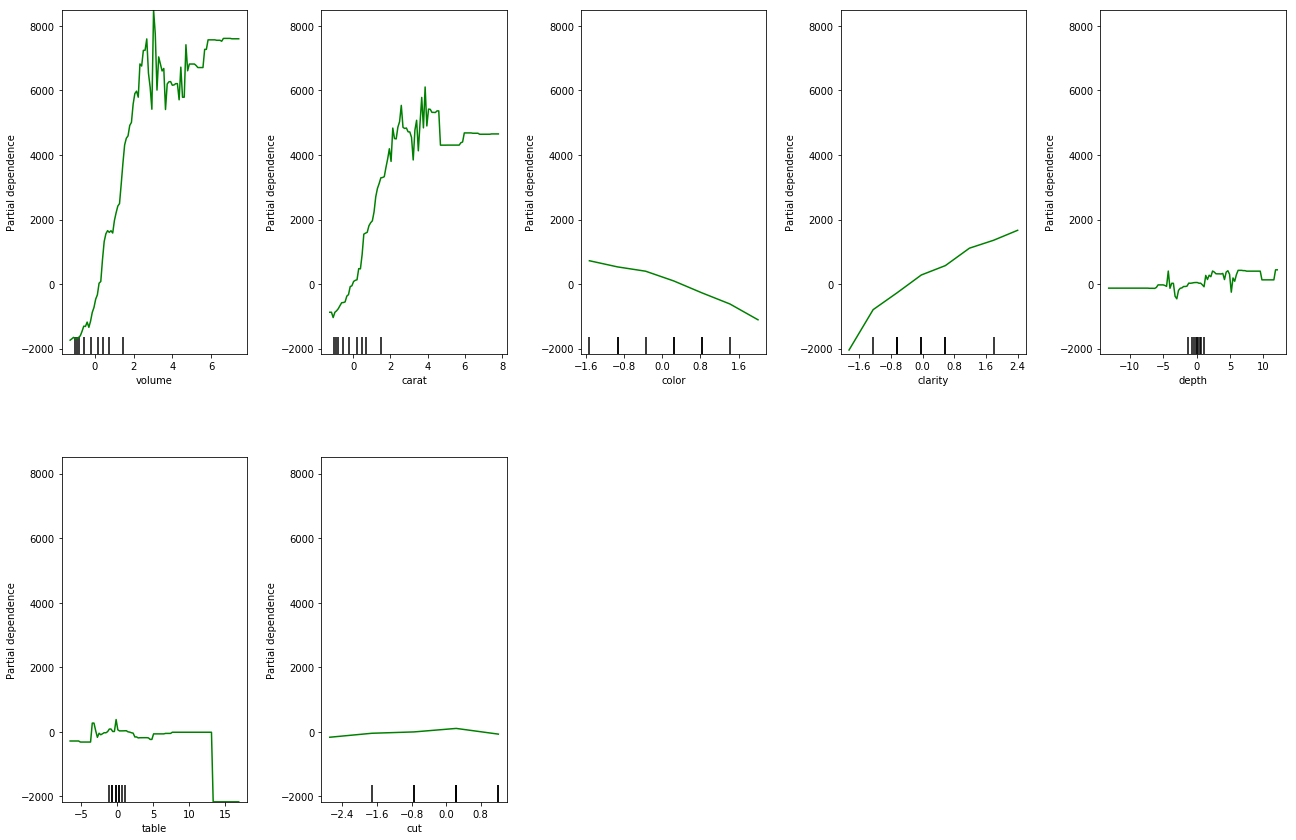

In [54]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

fig, ax = plot_partial_dependence(bt, Xs_train, indices, feature_names=features,
                                 percentiles=(0.0, 1.0), n_cols = 5)
fig.set_size_inches(20, 20)
plt.show()

Aquí podemos ver de nuevo como el precio depende mucho del volumen y también de los quilates